In [1]:
#General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt      
%matplotlib inline

#Sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import pickle

#Keras
from keras.utils import np_utils
from keras.layers import Dropout, Dense, Activation
from keras.models import Sequential
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping  
from keras.utils.np_utils import to_categorical

#import keras_metrics as km

Using TensorFlow backend.


# 1. Load data

In [2]:
data = pd.read_csv('data/original_data.csv')


In [3]:
print("Record length = ", len(data))
data.head()


Record length =  1142231


,CellID,countrycode,smsin,smsout,callin,callout,internet,label
0,1.0,39.0,1.7322,1.1047,0.5919,0.4020,57.7729,0
1,2.0,39.0,1.7334,1.0880,0.6020,0.4109,57.8875,0
2,3.0,39.0,1.7348,1.0701,0.6128,0.4203,58.0095,0
3,4.0,39.0,1.7284,1.1533,0.5627,0.3763,57.4408,0
4,5.0,39.0,1.5530,1.0439,0.5110,0.3503,52.1497,0


# 2. Create training, validation and testing data

### 2.1 Extract variables

In [4]:
# Separate target (y) and independent variables (X)
X = data.iloc[:,:7].values
y = data.iloc[:, 7].values


### 2.2 Split data into train and test set

In [5]:
# Training-Testing Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



### 2.3 Further split training set into training and validation sets

In [6]:
### Split data into train and valid set
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


# 3.Build Models

- Create Benchmark and Hybrid Models

## 3.1 Benchmark: Logistic Regression Model 

In [7]:
benchmark_classifier = LogisticRegression(random_state=0, 
                                          solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

In [8]:
# Save Model
filename = 'saved_models/benchmark_model.ckpt'
pickle.dump(benchmark_classifier, open(filename, 'wb'))

# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))

## 3.2 Hybridized Model: Artificial Neural Network (ANN)

### Construct ANN Classifier

In [9]:
class FFClassifier:
    ''' Class for ANN Classifier'''
    
    def __init__(self, train_data, valid_data,
                 target_train, target_valid, 
                 num_classes, dropout=0.5):
        '''Initialize dataset'''
        
        # Training/Validation Data
        self.X_train = train_data
        self.X_valid = valid_data
        self.y_train = target_train
        self.y_valid = target_valid
                
        # Encode target variables
        self.y_train_cat = to_categorical(target_train)
        self.y_valid_cat = to_categorical(target_valid)

        self.num_classes = num_classes
        self.dropout = dropout
        self.model = None

        
    def create_model(self, _input_dim):
        ''' Build simple ANN Model'''
        
        model = Sequential()
        model.add(Dense(64, input_dim=_input_dim))
        model.add(Activation('relu'))
        model.add(Dropout(self.dropout))

        model.add(Dense(32))
        model.add(Activation('relu'))
        model.add(Dropout(self.dropout))

        model.add(Dense(self.num_classes))
        model.add(Activation('softmax'))

        model.summary()
        self.model = model
    
        
    def compile_model(self, _optimizer, _loss, _metrics):
        ''' Set optimization and loss functions'''
        #self.model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
        self.model.compile(optimizer=_optimizer, 
                           loss=_loss, 
                           metrics= _metrics)
        print("\n\nModel successfully compiled!\n\n")
    

    def train_model(self, checkpoint_file, epochs=30):
        ''' Train the model and save to checkpoint '''
    
        train_tensors = self.X_train 
        train_targets = self.y_train_cat
        valid_tensors = self.X_valid
        valid_targets = self.y_valid_cat
        #print(train_tensors.shape, valid_tensors.shape, train_targets.shape, valid_targets.shape)

        early_stopping = EarlyStopping(monitor='val_loss', patience=2)

        checkpointer = ModelCheckpoint(filepath=checkpoint_file, 
                                       verbose=1, save_best_only=True)

        self.model.fit(train_tensors, train_targets, 
                  validation_data=(valid_tensors, valid_targets),
                  epochs=epochs, batch_size=64, callbacks=[checkpointer, early_stopping], verbose=1)

        return self.model


### Implement Classifier

In [10]:
# Set Parameters
_num_classes = 2
_dropout = 0.2
inp_dim = X_train2.shape[1]
optimizer = 'Adam' 
loss = 'categorical_crossentropy'
metrics = ['accuracy']
checkpoint = 'saved_models/hybrid_model.ckpt'

In [11]:
# Create Model
ffclassifier = FFClassifier(X_train2, X_valid, y_train2, y_valid, _num_classes, dropout=_dropout)
ffclassifier.create_model(inp_dim)
ffclassifier.compile_model(optimizer,loss,metrics)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                512       
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
__________

In [12]:
# Train Model
ffclassifier.train_model(checkpoint)

Train on 685338 samples, validate on 228446 samples
Epoch 1/30
685338/685338 [==============================] - 60s 87us/step - loss: 4.5870 - acc: 0.7128 - val_loss: 2.3201 - val_acc: 0.8528
Epoch 2/30
685338/685338 [==============================] - 59s 87us/step - loss: 0.3877 - acc: 0.9262 - val_loss: 0.0864 - val_acc: 0.9657
Epoch 3/30
685338/685338 [==============================] - 59s 86us/step - loss: 0.1132 - acc: 0.9549 - val_loss: 0.0975 - val_acc: 0.9576
Epoch 4/30
685338/685338 [==============================] - 59s 86us/step - loss: 0.1014 - acc: 0.9605 - val_loss: 0.0775 - val_acc: 0.9692
Epoch 5/30
685338/685338 [==============================] - 60s 87us/step - loss: 0.0969 - acc: 0.9633 - val_loss: 0.0815 - val_acc: 0.9682
Epoch 6/30
685338/685338 [==============================] - 59s 87us/step - loss: 0.0912 - acc: 0.9654 - val_loss: 0.0629 - val_acc: 0.9755
Epoch 7/30
685338/685338 [==============================] - 59s 86us/step - loss: 0.0874 - acc: 0.9667 - val

# 4.  Evaluation: Confusion Matrix Analysis

## 4.1 Construct Plot

In [14]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Code from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax, cm

## 4.2 Display Plots

### Confusion Matrix for Benchmark Model

Confusion matrix, without normalization
[[105616   7853]
 [ 14218 100760]]


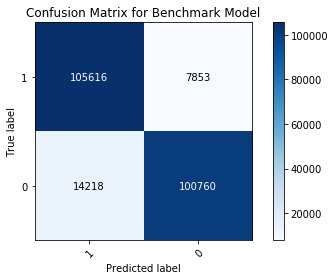

In [15]:
benchmark_preds = benchmark_classifier.predict(X_test) 

_, cm_benchmark = plot_confusion_matrix(y_test, benchmark_preds, classes=y_test, 
                                        title="Confusion Matrix for Benchmark Model")

From the Matrix Above:

- True Positive (TP) = 105616
- False Positive (FP) = 14218
- True Negative (TN) =  100760
- False Negative (FN) =  7853

### Confusion Matrix for Hybrid Model

In [20]:
_preds = ffclassifier.model.predict(X_test) 
hybrid_preds = np.argmax(_preds, axis=1)


Confusion matrix, without normalization
[[112489    980]
 [  4954 110024]]


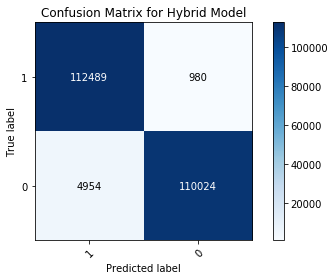

In [22]:
_, cm_hybrid = plot_confusion_matrix(y_test, hybrid_preds, classes=y_test, 
                                        title="Confusion Matrix for Hybrid Model")

From the Matrix Above:

- True Positive (TP) = 112489
- False Positive (FP) = 4954
- True Negative (TN) =  110024
- False Negative (FN) =  980

## 4.3 Define Metrics

In [23]:
class EvalMetrics:
    def __init__(self, tp, fp, tn, fn):
        ''' Initialize Confusion Matrix Values'''
        self.tp = tp
        self.fp = fp
        self.tn = tn
        self.fn = fn
        
    def get_accuracy(self):
        return (self.tp + self.tn) / (self.tp + self.fp + self.fn + self.tn)
    
    def get_precision(self):
        return self.tp / (self.tp + self.fp)

    def get_recall(self):
        return self.tp / (self.tp + self.fn)

    def get_f1_score(self):
        ''' Weighted average of Precision and Recall'''
        
        precision = self.get_precision()
        recall = self.get_recall()
        
        return (2*precision*recall) / (precision+recall)


## 4.4 Compute Metrics

### Benchmark Model

In [27]:
benchmark_metrics = EvalMetrics(105616, 14218, 100760, 7853)

print("Accuracy = {:.2f}%\nPrecision = {:.2f}%\nRecall = {:.2f}%\nF1-Score = {:.2f}%\n".format(100*benchmark_metrics.get_accuracy(),
                                                                          100*benchmark_metrics.get_precision(),
                                                                          100*benchmark_metrics.get_recall(),
                                                                          100*benchmark_metrics.get_f1_score()))


Accuracy = 90.34%
Precision = 88.14%
Recall = 93.08%
F1-Score = 90.54%



### Hybrid Model

In [29]:
hybrid_metrics = EvalMetrics(112489, 4954, 110024, 980)

print("Accuracy = {:.2f}%\nPrecision = {:.2f}%\nRecall = {:.2f}%\nF1-Score = {:.2f}%\n".format(100*hybrid_metrics.get_accuracy(),
                                                                          100*hybrid_metrics.get_precision(),
                                                                          100*hybrid_metrics.get_recall(),
                                                                          100*hybrid_metrics.get_f1_score()))


Accuracy = 97.40%
Precision = 95.78%
Recall = 99.14%
F1-Score = 97.43%



## 4.5 Further Evaluation with ROC Curve

### Benchmark Model

In [32]:
# ROC
benchmark_fpr, benchmark_tpr, benchmark_thresholds = roc_curve(y_test, benchmark_preds, pos_label=1)

# AUC
auc_benchmark = auc(benchmark_fpr, benchmark_tpr)

### Hybrid Model

In [33]:
# ROC
hybrid_fpr, hybrid_tpr, hybrid_thresholds = roc_curve(y_test, hybrid_preds, pos_label=1)

# AUC
auc_hybrid = auc(hybrid_fpr, hybrid_tpr)

### Display ROC

In [34]:
def plot_roc_curve(tpr_hybrid, fpr_hybrid, tpr_benchmark, fpr_benchmark, auc_hybrid, auc_benchmark):
    ''' 
        Source code adapted from: 
        https://hackernoon.com/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a
    '''
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_hybrid, tpr_hybrid, label='Hybrid Model (area = {:.3f})'.format(auc_hybrid))
    plt.plot(fpr_benchmark, tpr_benchmark, label='Benchmark Model (area = {:.3f})'.format(auc_benchmark))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
    # Zoom in view of the upper left corner.
    plt.figure(2)
    plt.xlim(0, 0.2)
    plt.ylim(0.8, 1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_hybrid, tpr_hybrid, label='Hybrid Model (area = {:.3f})'.format(auc_hybrid))
    plt.plot(fpr_benchmark, tpr_benchmark, label='Benchmark Model (area = {:.3f})'.format(auc_benchmark))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (zoomed in at top left)')
    plt.legend(loc='best')
    plt.show()

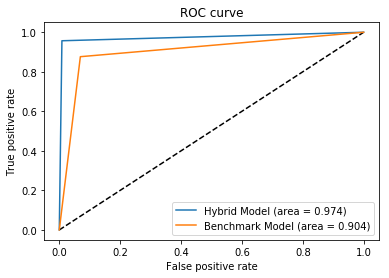

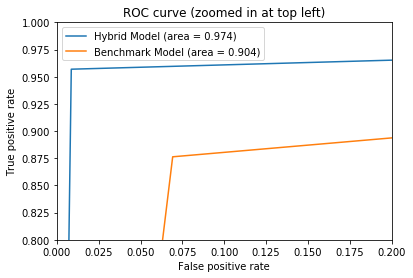

In [35]:
plot_roc_curve(hybrid_tpr, hybrid_fpr, benchmark_tpr, benchmark_fpr, auc_hybrid, auc_benchmark)